In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axisartist.axislines import AxesZero
from scipy.optimize import linprog


In [2]:
x = np.linspace(-2,2, 100)
y = np.linspace(-2,2, 100)
X, Y = np.meshgrid(x, y)

def dist2(x, y, x0=0, y0=0):
    return (x-x0)**2 + (y-y0)**2
def bump(x, y, x0=0, y0=0, c=1):
    return np.exp(-c*dist2(x, y, x0, y0))
def flu(x, y):
    return 1.25 * bump(x, y, -0.6, 0.25, 3) + bump(x, y, 0.6, -0.25, 4)
def flux(x):
    return flu(x, 0)

Z = flu(X, Y)


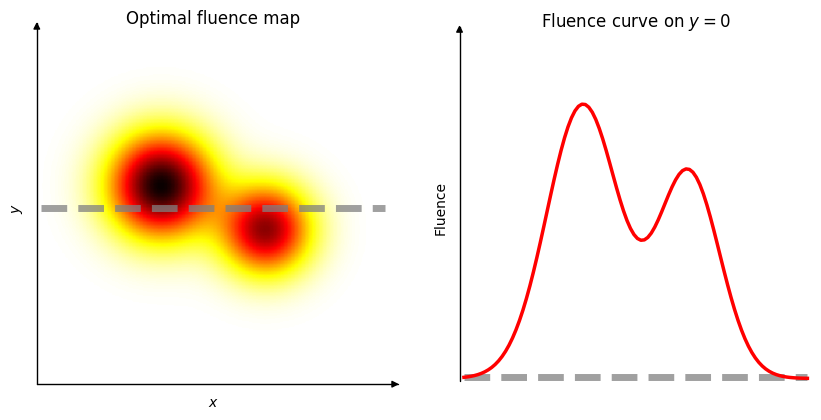

In [3]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1, axes_class=AxesZero)
plt.imshow(Z[::-1], cmap='hot_r', interpolation='hermite', extent=(-2,2,-2,2))
plt.plot([-1.95, 1.95], [0, 0], '--', color='grey', linewidth=5, alpha=0.75)
plt.xticks([])
plt.yticks([])
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.gca().axis["left"].set_axisline_style("-|>")
plt.gca().axis["bottom"].set_axisline_style("-|>")
plt.gca().axis["top"].set_visible(False)
plt.gca().axis["right"].set_visible(False)
plt.title('Optimal fluence map')

plt.subplot(1, 2, 2, axes_class=AxesZero)
# do not draw frame
plt.gca().axis["top"].set_visible(False)
plt.gca().axis["bottom"].set_visible(False)
plt.gca().axis["right"].set_visible(False)
plt.gca().axis["left"].set_axisline_style("-|>")
# plot red fluence
xs = np.linspace(-1.95, 1.95, 100)
plt.plot([-1.95, 1.95], [0.005, 0.005], '--', color='grey', linewidth=5, alpha=0.75)
plt.plot(xs, flux(xs), color='red', linewidth=2.5)
plt.xticks([])
plt.yticks([])
plt.xlim(-2,2)
plt.ylim(-0.01, 1.3)
plt.ylabel('Fluence')
plt.xlabel('$x$')
plt.gca().set_aspect(3, adjustable='box')
plt.title('Fluence curve on $y = 0$')

# plt.savefig('_fluence_curve.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [4]:
def leaf_sequence(fluence_values, power=1, max_speed=1):
    n = len(fluence_values)
    nb_var = 2 * n
    power_per_unit = power / (2*n)
    A = []
    b = []

    # costs
    c = np.ones(nb_var)

    # equality constraints
    for i in range(n):
        row = np.zeros(nb_var)
        row[i] = 1
        row[i + n] = -1
        A.append(row)
        b.append(fluence_values[i] / power_per_unit + 0.00001)
        
        row = np.zeros(nb_var)
        row[i] = -1
        row[i + n] = 1
        A.append(row)
        b.append(-fluence_values[i] / power_per_unit)

    # positive time constraints
    for i in range(nb_var):
        row = np.zeros(nb_var)
        row[i] = -1
        A.append(row)
        b.append(0)

    # max velocity constraints
    for i in range(n - 1):
        # left leafs
        row = np.zeros(nb_var)
        row[i] = 1
        row[i + 1] = -1
        A.append(row)
        b.append(-1 / max_speed)
        
        # right leafs
        row = np.zeros(nb_var)
        row[n + i] = 1
        row[n + i + 1] = -1
        A.append(row)
        b.append(-1 / max_speed)

    # no backward constraints
    for i in range(n - 1):
        # left leafs
        row = np.zeros(nb_var)
        row[i] = 1
        row[i + 1] = -1
        A.append(row)
        b.append(0)
        
        # right leafs
        row = np.zeros(nb_var)
        row[n + i] = 1
        row[n + i + 1] = -1
        A.append(row)
        b.append(0)

    A = np.array(A)
    b = np.array(b)

    # solve the problem with linprog
    res = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None) for _ in range(nb_var)])
    right_leaf_times = res.x[:n]
    left_leaf_times = res.x[n:]
    return left_leaf_times, right_leaf_times

# test setup
test_fluence = np.array([1, 2, 3, 2, 1, 0])
left_leaf_times, right_leaf_times = leaf_sequence(test_fluence)

print("Left Leaf Times:")
print(np.round(left_leaf_times, 2))
print("Right Leaf Times:")
print(np.round(right_leaf_times, 2))

Left Leaf Times:
[ 0.  1.  2. 15. 28. 41.]
Right Leaf Times:
[12. 25. 38. 39. 40. 41.]


In [5]:
def plot(fluence, n=7, power=1, max_speed=1, filename=None):
    XS = np.linspace(-2, 2, n)
    YS = fluence(XS)
    left_leaf_times, right_leaf_times = leaf_sequence(YS, power, max_speed)
    plt.figure(figsize=(6, 10))
    plt.subplots_adjust(hspace=0.02)
    
    plt.subplot(2, 1, 2, axes_class=AxesZero)
    plt.plot(XS, right_leaf_times, label='left leaf', color='#1F77B4')
    plt.plot(XS, left_leaf_times, label='right leaf', color='#1FAF59')
    plt.fill_between(XS, left_leaf_times, right_leaf_times, alpha=0.2, color='grey')
    plt.gca().invert_yaxis()
    plt.gca().axis["top"].set_visible(False)
    plt.gca().axis["bottom"].set_visible(False)
    plt.gca().axis["right"].set_visible(False)
    plt.gca().axis["left"].set_visible(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Optimal leaves motion', y=-0.01)
    plt.ylabel('Time')
    y_scale = plt.gca().get_ylim()[0]
    ymin = -y_scale*0.06
    ymax = y_scale*1.03
    plt.ylim(ymax, ymin)
    plt.gca().arrow(-2.1, 0, 0, y_scale, fc='k', ec='k', lw = 1, head_width=0.1, head_length=y_scale*0.025)
    plt.gca().text(-2.1, ymin/2, 'Time', va='center', ha='center')
    plt.xlim(-2.15, 2.15)

    plt.subplot(2, 1, 1, axes_class=AxesZero)
    if n<25:
        plt.plot(xs, flux(xs), color='red', linewidth=2.5, alpha=0.75)
        plt.plot(XS, YS,  color='black', linewidth=2.5)
        plt.title(f'Fluence {n}-pieces linear approximation')
    else:
        plt.plot(XS, YS,  color='red', linewidth=2.5)
        plt.title(f'Fluence')
    plt.fill_between(XS, YS, np.zeros_like(YS), alpha=0.1, color='grey')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-2.15, 2.15)
    plt.ylim( ymin/(2*n), ymax/(2*n))
    # plt.ylim(0, y_scale/(2*n))


    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()


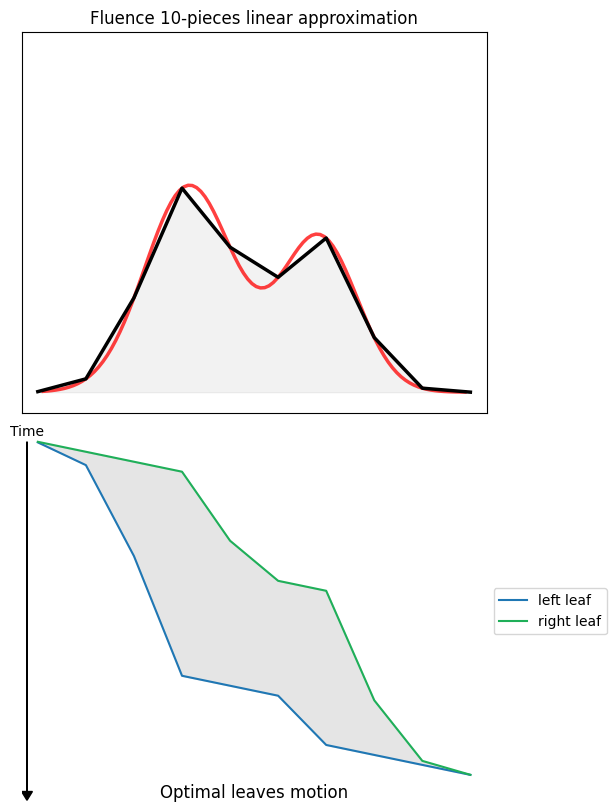

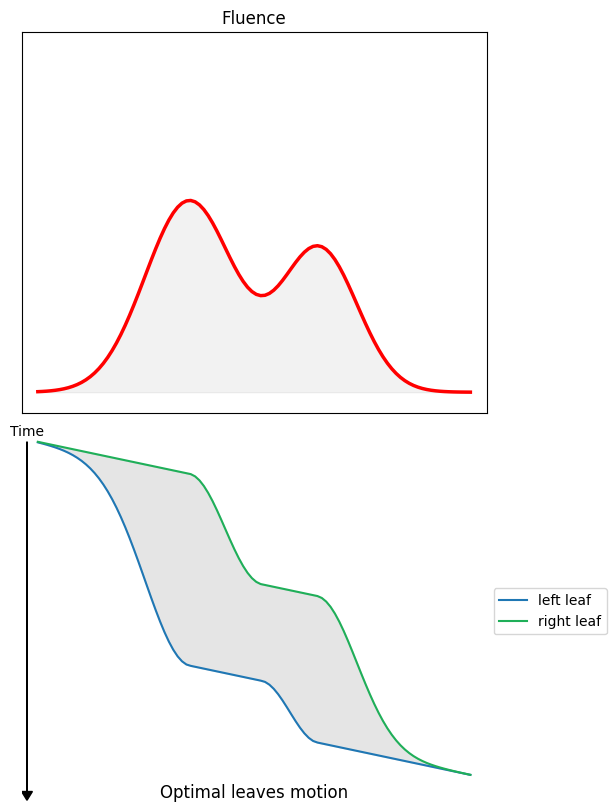

In [6]:
plot(flux, n=10)
plot(flux, n=100)
# plot(flux, n=10, filename='_fluence_leaf_sequencing_10.pdf')
# plot(flux, n=100, filename='_fluence_leaf_sequencing_100.pdf')
